<h2> Actor Critic Model </h2>

<p> Scenario 2 </p>
<ul> 
<li>There is an initial amount of 5,0000 given. The agent is prohibited from buying stocks if the account balance is <= $0</li> 
<li>There are service charge for stock transactions</li>
<li>The number of shares to buy in each transaction = 100</li>
<li>An episode terminates when all given data are tested or the account balance is negative </li>
<li>The training step = 1 day</li>
<li>The training time is reasonable because most of the episodes are terminated by negative account balances. </li>
</ul>


In [ ]:
#reference text
#https://books.google.com.sg/books?id=HnetDwAAQBAJ&pg=PT710&lpg=PT710&dq=replay+buffer+keras&source=bl&ots=kOYzzExOB5&sig=ACfU3U3A3YbvM4DuqReHvK1aYEtiDIpKUQ&hl=en&sa=X&ved=2ahUKEwiLtoHTk6zpAhXbeisKHUpCDkoQ6AEwA3oECAgQAQ#v=onepage&q=replay%20buffer%20keras&f=false
#https://towardsdatascience.com/how-to-train-your-quadcopter-adventures-in-machine-learning-algorithms-e6ee5033fd61
#https://towardsdatascience.com/understanding-and-implementing-distributed-prioritized-experience-replay-horgan-et-al-2018-d2c1640e0520
#https://github.com/PacktPublishing/Python-Reinforcement-Learning-Projects
#https://github.com/germain-hug/Deep-RL-Keras

In [1]:
from keras import layers, models, optimizers,regularizers,initializers
from keras import backend as K
import numpy as np
import pandas as pd
from numpy.random import choice
import random
from collections import namedtuple,deque
import math
import matplotlib.pyplot as plt

Using TensorFlow backend.


<h2> Understand Data </h2>

In [2]:
train_path =  'data/SPY_training.csv'
test_path = 'data/SPY_test.csv'

In [3]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [4]:
df = df_train.append(df_test)
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
# Remove spacing from columns headers
df.columns = [str(x).replace(' ', '_') for x in df.columns]
# Sort by datetime
df.sort_values(by='Date', inplace=True, ascending=True)
df.head(5)

,Date,Open,High,Low,Close,Adj_Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500


In [5]:
print("the date range of training dataset: ",df_train['Date'].min(), df_train['Date'].max())
print("the date range of test dataset: ",df_test['Date'].min(), df_test['Date'].max())

the date range of training dataset:  1993-01-29 2018-12-31
the date range of test dataset:  2019-01-02 2020-05-08


In [6]:
print("the size of training dataset: ", df_train.shape)
print("the size of test dataset: ",df_test.shape)
print ("the size of complete dataset: ",df.shape)

the size of training dataset:  (6528, 7)
the size of test dataset:  (341, 7)
the size of complete dataset:  (6869, 7)


In [7]:
print(df. describe())

              Open         High          Low        Close    Adj_Close  \
count  6869.000000  6869.000000  6869.000000  6869.000000  6869.000000   
mean    139.093952   139.916955   138.182487   139.093162   114.767321   
std      65.539873    65.795507    65.266381    65.548151    70.531779   
min      43.343750    43.531250    42.812500    43.406250    25.981276   
25%      98.580002    99.489998    97.470001    98.519997    71.126038   
50%     126.250000   127.080002   125.330002   126.160004    93.850166   
75%     165.600006   166.309998   164.860001   165.740005   144.523026   
max     337.790009   339.079987   337.480011   338.339996   336.362091   

             Volume  
count  6.869000e+03  
mean   8.476451e+07  
std    9.771849e+07  
min    5.200000e+03  
25%    7.437300e+06  
50%    5.766680e+07  
75%    1.225063e+08  
max    8.710263e+08  


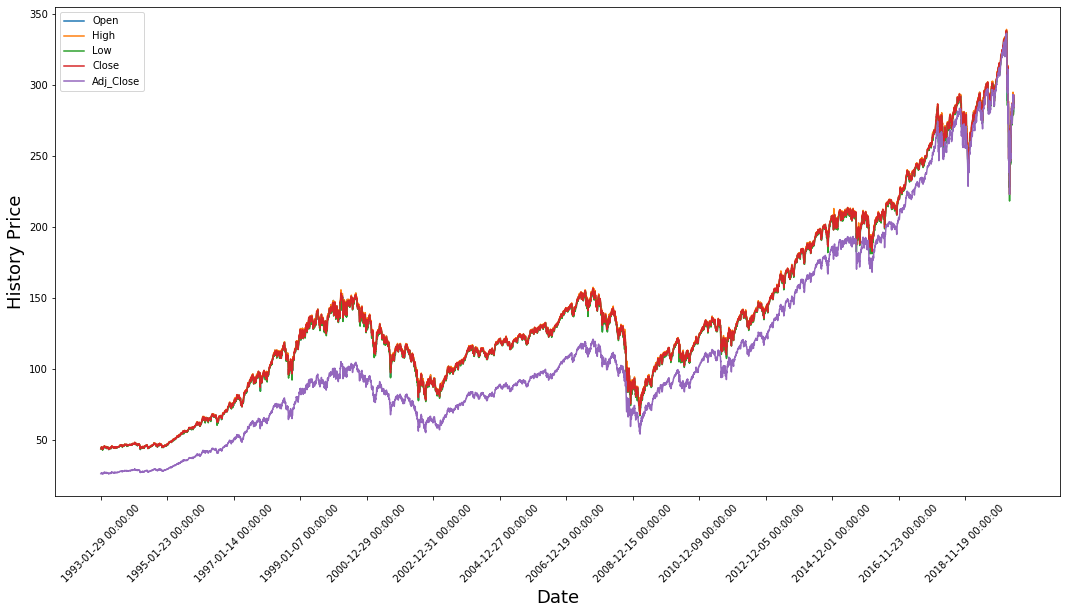

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Open']))
plt.plot(range(df.shape[0]),(df['High']))
plt.plot(range(df.shape[0]),(df['Low']))
plt.plot(range(df.shape[0]),(df['Close']))
plt.plot(range(df.shape[0]),(df['Adj_Close']))
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('History Price',fontsize=18)
plt.legend(['Open','High','Low','Close','Adj_Close'], loc='upper left')
plt.show()

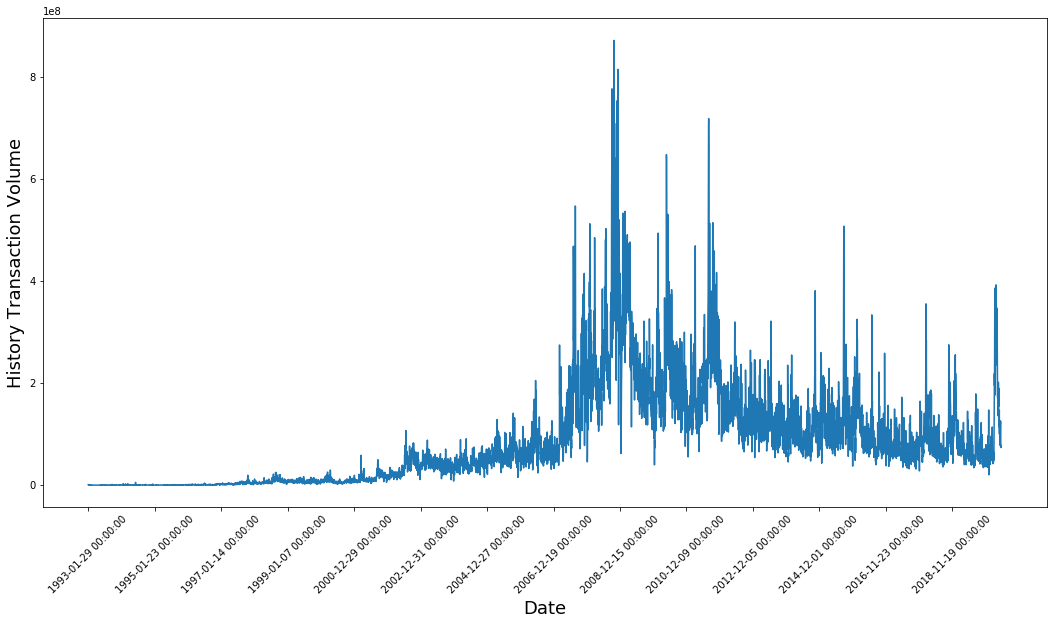

In [9]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Volume']))
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('History Transaction Volume',fontsize=18)
plt.show()

<p>The trend of open, high, low, close and adj close is similar<p>
<p>It seems when there is a price drop, there is a volume surge <p>

In [10]:
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64


<h4> Actor Network</h4> 
<p> Purpose: Define the actor (policy) model.The actor could be a neural network taking observations (states) as inputs and outputting one possible action. </p>
<p> Possible Improvements: Policy Search Improvement: When the policy space is big,finding a good set of parameters via brute force search is diffcult, in that case genetic algorithm can be used for more efficient policy search. Example: create a first generation of 100 random policies, evaluate their performance and remove 80 bad policies.Then make the surviving policies to cross-over and mutate to produce the second generation. Then the process iterates until an acceptable solution is found. </p>

In [11]:
#the aim of the training is to maximise the discounted accumulative rewards & minimise the negatives of Q-value
#could switch the model to keras sequential model
class Actor:
    def __init__(self, state_size, action_size):
        self. state_size = state_size
        self. action_size = action_size
        self. build_model()
    
    def build_model(self):
        #add states as the inputs
        states = layers.Input(shape=(self.state_size,), name='states')
        #dimensionality of the first output space=16 (16 neurons)
        net = layers.Dense(units=16,kernel_regularizer=regularizers.l2(1e-6))(states) 
        net = layers.BatchNormalization()(net) #Normalize and scale inputs which allows each layer of a network to learn by itself a little bit more independently of other layers
        net = layers.Activation("relu")(net)
        #dimensionality of the second output space= 32 (32 neurons)
        net = layers.Dense(units=32,kernel_regularizer=regularizers.l2(1e-6))(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation("relu")(net)  
        #dimensionality of the third output space= number of possible actions, each action is predicted with an probability
        actions = layers.Dense(units=self.action_size, activation='softmax', name = 'actions')(net)
        #the models class groups layers into an object with training and inference features.
        self.model = models.Model(inputs=states, outputs=actions)
        #model.save('data/actor_model')
        #define the loss function by using the action value (Q_value) gradients, for policy evaluation 
        action_gradients = layers.Input(shape=(self.action_size,))
        loss = K.mean(-action_gradients * actions) #the aims is to minimise the negatives of Q-values
        #define the optimizer and train the function
        optimizer = optimizers.Adam(lr=.0001)
        updates_op = optimizer.get_updates(params=self.model.trainable_weights, loss=loss)
        self.train_fn = K.function(inputs=[self.model.input, action_gradients, K.learning_phase()],outputs=self.model.output,updates=updates_op)


<h4> Critic Network </h4>
<p> Purpose: Build a critic (value) network that maps state and action pairs
(Q_values) </p>

In [12]:
class Critic:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.build_model()

    def build_model(self):
        states = layers.Input(shape=(self.state_size,), name='states')
        actions = layers.Input(shape=(self.action_size,), name='actions')
        net_states = layers.Dense(units=16,kernel_regularizer=regularizers.l2(1e-6))(states)
        net_states = layers.BatchNormalization()(net_states)
        net_states = layers.Activation("relu")(net_states)
        #two inputs dense to same shapes
        net_states = layers.Dense(units=32, kernel_regularizer=regularizers.l2(1e-6))(net_states)
        net_actions = layers.Dense(units=32,kernel_regularizer=regularizers.l2(1e-6))(actions)
        #add the two inputs
        net = layers.Add()([net_states, net_actions])
        net = layers.Activation('relu')(net)
        #the final output layer will produce the Q-value state -action value
        Q_values = layers.Dense(units=1, name='q_values',kernel_initializer=initializers.RandomUniform(minval=-0.003, maxval=0.003))(net)
        self.model = models.Model(inputs=[states, actions], outputs=Q_values)
        optimizer = optimizers.Adam(lr=0.0001)
        self.model.compile(optimizer=optimizer, loss='mse')
        action_gradients = K.gradients(Q_values, actions)
        self.get_action_gradients = K.function(inputs=[*self.model.input, K.learning_phase()],outputs=action_gradients)

<h4> Agent </h4>
<p> Purpose: define an agent to train the actor and critic </p>

In [13]:
'''instead of training the DQN on the latest experiences, we will store all experiences in a replay buffer
   or a replay memory and we will sample a random training from it at each training iteration. This helps to reduce
   the correlation between the experiences in a training batch, which tremendously help training.
'''
# prioritized Experience Replay /importance sampling (sample important experiences more frequently)
#https://towardsdatascience.com/understanding-and-implementing-distributed-prioritized-experience-replay-horgan-et-al-2018-d2c1640e0520

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    #Add a new experience to the replay buffer memory
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    # randomly sample states from a memory buffer to improve overfitting
    def sample(self, batch_size=32):
        return random.sample(self.memory, k=self.batch_size)
    #Return the current size of the buffer memory
    def __len__(self):
        return len(self.memory)

<p>Possible Improvements: Policy Gradient </p>

In [14]:
#learns via actor and agent networks
class Agent:
    def __init__(self, state_size, batch_size, is_eval = False):
        #replay memory size
        self.state_size = state_size
        self.action_size = 3 #3 actions: buy, sell, hold
        self.buffer_size = 1000000
        self.batch_size = batch_size
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)
        self.inventory = []
        self.share= []
        #whether or not training is ongoing. This variable will be changed during the training and evaluation phase
        self.is_eval = is_eval 
        #discount factor in Bellman equation
        self.gamma = 0.99
        #a soft update of the actor and critic networks
        self.tau = 0.001
        #the actor policy model maps states to actions
        self.actor_local = Actor(self.state_size, self.action_size)
        self.actor_target = Actor(self.state_size, self.action_size)
        self.actor_target.model.set_weights(self.actor_local.model.get_weights()) #sets the target model parameters to local model parameters
        #the critic (value) model  maps the state-action pairs to Q_values 
        self.critic_local = Critic(self.state_size, self.action_size)
        self.critic_target = Critic(self.state_size, self.action_size)
        self.critic_target.model.set_weights(self.critic_local.model.get_weights()) 
    
    #the function will return the actions with probability distributions, given a state, using the actor (policy) network
    #the action with highest probability is the best action to given the state (best action to take)
    def act(self, state):
        options = self.actor_local.model.predict(state)
        self.last_state = state
        if not self.is_eval:
            return choice(range(3), p = options[0])
        return np.argmax(options[0])
    
    #the function will assign a stochastic policy, based on the action probabilities in the training model
    #the function will assign a deterministic action corresponding to the maximum probability in the testing model
    #the function will return the set of actions carried by the agent in each episode (all steps are recorded)
    def step(self, action, reward, next_state, done):
        self.memory.add(self.last_state, action, reward, next_state, done) #adds a new experience to the memory
        if len(self.memory) > self.batch_size: #when enough experiences are presented in memory for training 
            experiences = self.memory.sample(self.batch_size)# a ranfom sample will be pulled for training 
            self.learn(experiences) #the agent then learns from the sample experience
            self.last_state = next_state #update the state to next state
    
    #the function will learned the sampled experiences through the actor and the critic
    def learn(self, experiences):               
        states = np.vstack([e.state for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.state_size)    
        actions = np.vstack([e.action for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.action_size)
        rewards = np.array([e.reward for e in experiences if e is not None]).astype(np.float32).reshape(-1,1)
        dones = np.array([e.done for e in experiences if e is not None]).astype(np.float32).reshape(-1,1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.state_size)

        actions_next = self.actor_target.model.predict_on_batch(next_states)
        Q_targets_next = self.critic_target.model.predict_on_batch([next_states, actions_next])
        
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        self.critic_local.model.train_on_batch(x = [states, actions], y=Q_targets)
        
        action_gradients = np.reshape(self.critic_local.get_action_gradients([states, actions, 0]),(-1, self.action_size))
        self.actor_local.train_fn([states, action_gradients, 1])
        self.soft_update(self.critic_local.model, self.critic_target.model)  
        self.soft_update(self.actor_local.model, self.actor_target.model)
    
    #the function performs soft updates on the model parameters to avoid drastic model changes
    def soft_update(self, local_model, target_model):
        local_weights = np.array(local_model.get_weights())
        target_weights = np.array(target_model.get_weights())

        assert len(local_weights) == len(target_weights)

        new_weights = self.tau * local_weights + (1 - self.tau) * target_weights
        target_model.set_weights(new_weights)


<h4> Utility Functions </h4>

In [15]:
#utility functions
def formatPrice(n):
    if n >= 0:
        curr = "$"
    else:
        curr = "-$"
    return curr + "{0:.2f}".format(abs(n))


def getStockData(key):
    datavec = []
    lines = open("data/" + key + ".csv", "r").read().splitlines()
    
    for line in lines[1:]:
        datavec.append(float(line.split(",")[4]))
    
    return datavec
  
#The function for this takes three parameters: the data; a time, t (the day that you want to predict); 
#and a window (how many days to go back in time)
def getState(data, t, window):
    if t - window >= -1:
        vec = data[t - window + 1:t + 1]
    else: 
        vec = -(t-window+1)*[data[0]]+data[0: t + 1]
    #Nscale the state vector from 0 to 1 with a sigmoid function.
    #The sigmoid function can map any input value, from 0 to 1. This helps to normalize the values to probabilities.
    scaled_state = []
    for i in range(window - 1):
        scaled_state.append(1/(1 + math.exp(vec[i] - vec[i+1])))
    
    return np.array([scaled_state])

<h4> Train and Test </h4>

In [16]:
window_size = 100
batch_size = 32
agent = Agent(window_size, batch_size)
df_train = getStockData("SPY_training")
len_train = len(df_train) - 1
episode_count = 150
summary = []

for e in range(episode_count):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(df_train, 0, window_size + 1) #first state in an epsiode
    agent.inventory = []
    agent.share =[]
    initial_amount = 50000
    final_amount = 50000
    total_profit = 0
    done = False
    
    for t in range(len_train):
        action = agent.act(state)
        action_prob = agent.actor_local.model.predict(state)
        next_state = getState(df_train, t + 1, window_size + 1)
        reward = 0
        
        #every day, agent has to decide an action: buy,sell or hold
        #if action==0, there is no action needed to be carried out (hold the stock)
        #if the action =1, buy the stock on the day, the quantity is always set to 1
        if action == 1 and final_amount >= df_train[t]*500:
            agent.inventory.append(df_train[t])
            share = 500 #TODO: Setup a new policy to guide the amount of share to buy
            agent.share.append(share)
            commission_cost = max(1, share*df_train[t]*0.001)
            final_amount = final_amount - df_train[t]*share - commission_cost
            print("At timestep " + str(t) + ", Buy: " + formatPrice(df_train[t])+ "* 500" + ", Balance= " + str (final_amount))       
        #if the action ==2, sell some of the stocks bought previously
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            #reward = max(df_train[t] - bought_price, 0)
            bought_share = agent.share.pop(0)
            profit = df_train[t]*bought_share - bought_price*bought_share
            commission_cost = max(1, bought_share*df_train[t]*0.001)
            reward = max(profit-commission_cost*2,0) #service charge buy & service charge sell
            final_amount = final_amount + df_train[t]*bought_share -commission_cost 
            print("At timestep " + str(t) + ", Sell: " + formatPrice(df_train[t])+ "* 500"+ ", Profit: " + formatPrice(profit - commission_cost*2) + ", Balance= " + str (final_amount))
        else:
            pass

        if (t == len_train - 1) or (final_amount <= 0 and len(agent.inventory) <= 0 ): 
            done = True
        
        agent.step(action_prob, reward, next_state, done)
        state = next_state

        if done == True:
            #TODO: to implement the function in a more elegant manner, to sold out whatever left at terminal state
            if len(agent.inventory) > 0:
                for i in range (len(agent.inventory)-1):
                    bought_price = agent.inventory.pop(0)
                    bought_share = agent.share.pop(0)
                    profit = df_train[t]*bought_share - bought_price*bought_share
                    commission_cost = max(1, bought_share*df_train[t]*0.001)
                    final_amount = final_amount + df_train[t]*bought_share -commission_cost 
            if final_amount > 0:
                total_profit = final_amount - initial_amount
            else:
                total_profit = final_amount + initial_amount   
            print("------------------------------------------")
            print("Final Amount: " + formatPrice(final_amount))
            print("Total Profit/Loss: " + formatPrice(total_profit))
            print("------------------------------------------")
            summary.append(total_profit)
            print(summary)
            break

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Episode 0/150
At timestep 0, Buy: $43.94* 500, Balance= 28009.28125
At timestep 1, Buy: $44.25* 500, Balance= 5862.15625
At timestep 2, Sell: $44.34* 500, Profit: $158.78, Balance= 28011.859375
At timestep 4, Sell: $45.00* 500, Profit: $330.00, Balance= 50489.359375
At timestep 6, Buy: $44.97* 500, Balance= 27982.5
At timestep 7, Buy: $44.66* 500, Balance= 5632.046875
At timestep 9, Sell: $44.94* 500, Profit: -$60.56, Balance= 28078.328125
At timestep 10, Buy: $44.59* 500, Balance= 5759.15625
At timestep 11, Sell: $43.47* 500, Profit: -$637.22, Balance= 27471.796875
At timestep 12, Sell: $43.44* 500, Profit: -$621.56, Balance= 49168.828125
At timestep 14, Buy: $43.56* 500, Balance= 27365.796875
At timestep 17, Sell: $44.25* 500, Profit: $299.50, Balance= 49468.671875
At timestep 26, Buy: $45.59* 500, Balance= 26649.0
At timestep 27, Sell: $45.69* 500, Profit: $1.19, Balance= 49469.90625
At timestep 28, Bu

At timestep 309, Sell: $44.31* 500, Profit: -$122.44, Balance= 23271.3125
At timestep 310, Sell: $44.91* 500, Profit: $111.34, Balance= 45701.984375
At timestep 312, Buy: $45.33* 500, Balance= 23015.2578125
At timestep 313, Buy: $45.28* 500, Balance= 351.9921875
At timestep 321, Sell: $44.36* 500, Profit: -$528.73, Balance= 22509.5
At timestep 323, Buy: $44.30* 500, Balance= 338.9140625
At timestep 325, Sell: $44.52* 500, Profit: -$427.33, Balance= 22574.46875
At timestep 326, Buy: $44.53* 500, Balance= 286.578125
At timestep 328, Sell: $45.52* 500, Profit: $563.86, Balance= 23021.6328125
At timestep 329, Sell: $45.73* 500, Profit: $555.83, Balance= 45865.953125
At timestep 331, Buy: $45.48* 500, Balance= 23101.0234375
At timestep 333, Sell: $45.80* 500, Profit: $110.45, Balance= 45976.5625
At timestep 334, Buy: $45.83* 500, Balance= 23039.5859375
At timestep 335, Sell: $45.88* 500, Profit: -$22.44, Balance= 45954.1484375
At timestep 337, Buy: $46.02* 500, Balance= 22923.328125
At time

At timestep 611, Sell: $54.41* 500, Profit: -$70.03, Balance= 48453.5546875
At timestep 613, Buy: $54.81* 500, Balance= 21019.8984375
At timestep 614, Sell: $55.52* 500, Profit: $296.05, Balance= 48749.953125
At timestep 615, Buy: $55.77* 500, Balance= 20839.2578125
At timestep 616, Sell: $55.80* 500, Profit: -$40.17, Balance= 48709.796875
At timestep 617, Buy: $55.53* 500, Balance= 20916.40625
At timestep 619, Sell: $56.09* 500, Profit: $225.16, Balance= 48935.234375
At timestep 621, Buy: $56.36* 500, Balance= 20727.3671875
At timestep 624, Sell: $55.47* 500, Profit: -$500.78, Balance= 48434.0078125
At timestep 625, Buy: $55.41* 500, Balance= 20703.1796875
At timestep 631, Sell: $56.16* 500, Profit: $318.84, Balance= 48753.2265625
At timestep 632, Buy: $56.06* 500, Balance= 20693.9453125
At timestep 648, Sell: $55.92* 500, Profit: -$126.23, Balance= 48626.921875
At timestep 650, Buy: $56.30* 500, Balance= 20450.3359375
At timestep 653, Sell: $56.36* 500, Profit: -$25.11, Balance= 4860

At timestep 899, Buy: $66.83* 500, Balance= 13312.4375
At timestep 909, Sell: $65.81* 500, Profit: -$573.62, Balance= 46185.78125
At timestep 910, Buy: $65.02* 500, Balance= 13645.4609375
At timestep 911, Sell: $65.94* 500, Profit: $395.00, Balance= 46581.2421875
At timestep 912, Buy: $66.72* 500, Balance= 13188.5078125
At timestep 916, Sell: $68.56* 500, Profit: $853.31, Balance= 47435.4765625
At timestep 919, Buy: $68.48* 500, Balance= 13159.046875
At timestep 921, Sell: $68.64* 500, Profit: $9.48, Balance= 47445.0390625
At timestep 922, Buy: $68.62* 500, Balance= 13098.2265625
At timestep 924, Sell: $68.66* 500, Profit: -$53.03, Balance= 47392.0234375
At timestep 926, Buy: $68.69* 500, Balance= 13013.9296875
At timestep 927, Sell: $68.62* 500, Profit: -$99.88, Balance= 47292.1171875
At timestep 930, Buy: $69.41* 500, Balance= 12554.2890625
At timestep 933, Sell: $70.14* 500, Profit: $297.05, Balance= 47589.53125
At timestep 935, Buy: $69.45* 500, Balance= 12828.2421875
At timestep 9

At timestep 1185, Sell: $98.19* 500, Profit: $917.44, Balance= 51882.9375
At timestep 1186, Buy: $97.50* 500, Balance= 3084.1875
At timestep 1196, Sell: $96.84* 500, Profit: -$424.97, Balance= 51457.640625
At timestep 1197, Buy: $94.94* 500, Balance= 3941.421875
At timestep 1199, Sell: $87.19* 500, Profit: -$3962.19, Balance= 47491.578125
At timestep 1200, Buy: $92.22* 500, Balance= 1336.09375
At timestep 1203, Sell: $92.06* 500, Profit: -$170.19, Balance= 47321.3125
At timestep 1204, Buy: $94.00* 500, Balance= 274.3125
At timestep 1205, Sell: $94.00* 500, Profit: -$94.00, Balance= 47227.3125
At timestep 1206, Buy: $94.31* 500, Balance= 23.90625
At timestep 1207, Sell: $93.95* 500, Profit: -$273.64, Balance= 46953.4921875
At timestep 1208, Buy: $92.94* 500, Balance= 438.2734375
At timestep 1209, Sell: $92.38* 500, Profit: -$373.62, Balance= 46579.5859375
At timestep 1211, Buy: $90.50* 500, Balance= 1284.3359375
At timestep 1213, Sell: $93.06* 500, Profit: $1188.19, Balance= 47769.05468

At timestep 2578, Sell: $91.36* 500, Profit: $4928.64, Balance= 49549.32219100006
At timestep 2579, Buy: $90.23* 500, Balance= 4389.205689500059
At timestep 2581, Sell: $92.11* 500, Profit: $847.89, Balance= 50398.15118900006
At timestep 2582, Buy: $91.91* 500, Balance= 4397.194187000062
At timestep 2588, Sell: $92.45* 500, Profit: $177.55, Balance= 50575.96768850006
At timestep 2589, Buy: $93.73* 500, Balance= 3664.1011870000607
At timestep 2596, Sell: $92.46* 500, Profit: -$727.46, Balance= 49847.87068750006
At timestep 2597, Buy: $92.65* 500, Balance= 3476.544686500053
At timestep 2602, Sell: $95.42* 500, Profit: $1289.58, Balance= 51138.83368750006
At timestep 2603, Buy: $96.95* 500, Balance= 2615.360189000059
At timestep 2607, Sell: $99.65* 500, Profit: $1250.35, Balance= 52390.536188000064
At timestep 2609, Buy: $98.25* 500, Balance= 3216.4111880000637
At timestep 2638, Sell: $98.28* 500, Profit: -$83.28, Balance= 52307.270688500066
At timestep 2639, Buy: $99.17* 500, Balance= 26

At timestep 3935, Sell: $126.09* 500, Profit: -$776.09, Balance= 64186.79568149995
At timestep 3936, Buy: $120.09* 500, Balance= 4081.7526834999494
At timestep 3955, Sell: $88.50* 500, Profit: -$15883.50, Balance= 48287.50268349995
At timestep 3958, Buy: $90.02* 500, Balance= 3232.49418499995
At timestep 3973, Sell: $96.19* 500, Profit: $2988.81, Balance= 51279.400183999955
At timestep 3974, Buy: $90.86* 500, Balance= 5803.969683499952
At timestep 3975, Sell: $93.86* 500, Profit: $1406.14, Balance= 52687.04018299996
At timestep 3977, Buy: $89.77* 500, Balance= 7757.15668449996
At timestep 4005, Sell: $87.06* 500, Profit: -$1442.06, Balance= 51243.62568549996
At timestep 4006, Buy: $86.16* 500, Balance= 8120.543683499959
At timestep 4024, Sell: $84.05* 500, Profit: -$1139.05, Balance= 50103.52018199996
At timestep 4025, Buy: $82.75* 500, Balance= 8687.145181999957
At timestep 4056, Sell: $68.11* 500, Profit: -$7388.11, Balance= 42708.09068149996
At timestep 4057, Buy: $72.17* 500, Balan

At timestep 139, Sell: $45.78* 500, Profit: $79.22, Balance= 51301.84375
At timestep 141, Buy: $45.81* 500, Balance= 28372.6875
At timestep 142, Sell: $45.72* 500, Profit: -$92.59, Balance= 51209.203125
At timestep 143, Buy: $46.22* 500, Balance= 28076.71875
At timestep 144, Sell: $46.25* 500, Profit: -$30.62, Balance= 51178.59375
At timestep 145, Buy: $46.28* 500, Balance= 28014.828125
At timestep 146, Sell: $46.25* 500, Profit: -$61.88, Balance= 51116.703125
At timestep 148, Buy: $46.56* 500, Balance= 27812.171875
At timestep 149, Sell: $46.50* 500, Profit: -$77.75, Balance= 51038.921875
At timestep 152, Buy: $46.06* 500, Balance= 27984.640625
At timestep 153, Sell: $45.91* 500, Profit: -$124.03, Balance= 50914.8125
At timestep 161, Buy: $45.44* 500, Balance= 28173.34375
At timestep 162, Sell: $45.28* 500, Profit: -$123.41, Balance= 50791.328125
At timestep 164, Buy: $45.91* 500, Balance= 27815.25
At timestep 165, Sell: $45.78* 500, Profit: -$108.28, Balance= 50682.984375
At timestep

At timestep 358, Sell: $44.47* 500, Profit: -$185.09, Balance= 44225.9921875
At timestep 359, Buy: $44.56* 500, Balance= 21922.4609375
At timestep 368, Sell: $45.39* 500, Profit: $368.67, Balance= 44595.078125
At timestep 369, Buy: $45.47* 500, Balance= 21837.96875
At timestep 370, Sell: $45.38* 500, Profit: -$92.25, Balance= 44502.78125
At timestep 371, Buy: $45.17* 500, Balance= 21894.2578125
At timestep 372, Sell: $45.27* 500, Profit: $1.61, Balance= 44504.4375
At timestep 373, Buy: $45.34* 500, Balance= 21809.890625
At timestep 375, Sell: $45.36* 500, Profit: -$37.55, Balance= 44466.8984375
At timestep 377, Buy: $45.45* 500, Balance= 21717.609375
At timestep 378, Sell: $45.91* 500, Profit: $180.66, Balance= 44647.78125
At timestep 379, Buy: $46.12* 500, Balance= 21562.21875
At timestep 388, Sell: $46.33* 500, Profit: $55.23, Balance= 44703.1171875
At timestep 389, Buy: $46.31* 500, Balance= 21523.7109375
At timestep 392, Sell: $46.45* 500, Profit: $23.86, Balance= 44727.046875
At t

At timestep 673, Sell: $58.59* 500, Profit: -$144.53, Balance= 45961.390625
At timestep 674, Buy: $58.48* 500, Balance= 16689.9609375
At timestep 679, Sell: $58.41* 500, Profit: -$97.47, Balance= 45863.8828125
At timestep 680, Buy: $57.92* 500, Balance= 16873.984375
At timestep 682, Sell: $58.08* 500, Profit: $20.05, Balance= 45884.0078125
At timestep 683, Buy: $58.44* 500, Balance= 16636.0390625
At timestep 700, Sell: $59.03* 500, Profit: $237.84, Balance= 46122.1484375
At timestep 701, Buy: $58.81* 500, Balance= 16686.4921875
At timestep 702, Sell: $59.34* 500, Profit: $206.28, Balance= 46328.6953125
At timestep 704, Buy: $59.53* 500, Balance= 16533.3046875
At timestep 706, Sell: $59.08* 500, Profit: -$285.64, Balance= 46042.828125
At timestep 707, Buy: $59.67* 500, Balance= 16177.0546875
At timestep 730, Sell: $61.27* 500, Profit: $735.61, Balance= 46779.234375
At timestep 731, Buy: $60.67* 500, Balance= 16412.9609375
At timestep 735, Sell: $61.47* 500, Profit: $336.97, Balance= 471

At timestep 1297, Sell: $109.25* 500, Profit: $1234.50, Balance= 62745.765625
At timestep 1298, Buy: $109.88* 500, Balance= 7753.328125
At timestep 1325, Sell: $109.31* 500, Profit: -$390.56, Balance= 62354.921875
At timestep 1326, Buy: $111.34* 500, Balance= 6627.375
At timestep 1349, Sell: $107.88* 500, Profit: -$1842.25, Balance= 60510.9375
At timestep 1351, Buy: $112.00* 500, Balance= 4454.9375
At timestep 1352, Sell: $111.88* 500, Profit: -$174.38, Balance= 60336.5
At timestep 1353, Buy: $112.22* 500, Balance= 4171.015625
At timestep 1354, Sell: $111.50* 500, Profit: -$470.88, Balance= 59865.265625
At timestep 1355, Buy: $109.41* 500, Balance= 5107.4375
At timestep 1363, Sell: $111.91* 500, Profit: $1138.09, Balance= 61004.609375
At timestep 1364, Buy: $113.41* 500, Balance= 4244.78125
At timestep 1370, Sell: $114.84* 500, Profit: $603.91, Balance= 61609.234375
At timestep 1371, Buy: $116.00* 500, Balance= 3551.234375
At timestep 1375, Sell: $116.47* 500, Profit: $117.91, Balance=

At timestep 3701, Sell: $156.48* 500, Profit: $5188.52, Balance= 79593.87599500002
At timestep 3702, Buy: $156.22* 500, Balance= 1405.7654945000293
At timestep 3788, Sell: $136.37* 500, Profit: -$10061.37, Balance= 69522.57799700003
At timestep 3789, Buy: $135.17* 500, Balance= 1869.9939980000333
At timestep 3818, Sell: $131.51* 500, Profit: -$1961.51, Balance= 67559.23650050003
At timestep 3819, Buy: $131.97* 500, Balance= 1508.2510000000373
At timestep 4014, Sell: $93.47* 500, Profit: -$19343.47, Balance= 48196.51649950004
At timestep 4015, Buy: $90.67* 500, Balance= 2816.182500500034
At timestep 4026, Sell: $83.11* 500, Profit: -$3863.11, Balance= 44329.62800000004
At timestep 4027, Buy: $83.68* 500, Balance= 2447.7880000000405
At timestep 4095, Sell: $90.88* 500, Profit: $3509.12, Balance= 47842.34650150005
At timestep 4096, Buy: $90.57* 500, Balance= 2512.0615015000476
At timestep 4329, Sell: $118.77* 500, Profit: $13981.23, Balance= 61837.675003000055
At timestep 4330, Buy: $119.

------------------------------------------
Final Amount: $50000.00
Total Profit/Loss: $0.00
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0]
Episode 10/150
------------------------------------------
Final Amount: $50000.00
Total Profit/Loss: $0.00
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0]
Episode 11/150
------------------------------------------
Final Amount: $50000.00
Total Profit/Loss: $0.00
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0]
Episode 12/150
------------------------------------------
Final Amount: $50000.00
Total Profit/Loss: $0.00
-----------

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125]
Episode 21/150
At timestep 0, Buy: $43.94* 500, Balance= 28009.28125
At timestep 1, Buy: $44.25* 500, Balance= 5862.15625
------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125]
Episode 22/150
At timestep 0, Buy: $43.94* 500, Balance= 28009.28125
At timestep 1, Buy: $44.25* 50

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125]
Episode 35/150
At timestep 0, Buy: $43.94* 500, Balance= 28009.28125
At timestep 1, Buy: $44.25* 500, Balance= 5862.15625
------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.543686

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125]
Episode 46/150
At timestep 0, Buy: $43.94* 500, Balance= 28009.28125
At timestep 1, Buy: $44.25* 500, Balance= 5862.15625
------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.10

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125]
Episode 56/150
At timestep 0, Buy: $43.94* 500, Balance= 28009.28125
At timestep 1, Buy: $44.25* 500, Balance= 5862.15625
----------------------------------------

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125]
Episode 65/150
At timestep 0, Buy: $43.94* 50

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.

At timestep 3497, Sell: $143.12* 500, Profit: $2111.88, Balance= 75380.690249
At timestep 3498, Buy: $142.34* 500, Balance= 4139.522250999999
At timestep 3513, Sell: $141.54* 500, Profit: $1118.45, Balance= 74838.7487545
At timestep 3514, Buy: $142.16* 500, Balance= 3687.6667525000107
At timestep 3523, Sell: $142.26* 500, Profit: -$182.26, Balance= 74746.534255
At timestep 3525, Sell: $142.05* 500, Profit: -$197.05, Balance= 145700.5107535
At timestep 3533, Buy: $145.02* 500, Balance= 73117.99875150002
At timestep 3534, Buy: $143.94* 500, Balance= 1076.0277505000356
At timestep 3537, Sell: $145.61* 500, Profit: $149.39, Balance= 73808.22325000005
At timestep 3539, Buy: $145.73* 500, Balance= 870.3602520000468
At timestep 3559, Sell: $140.20* 500, Profit: -$2010.20, Balance= 70900.25875350005
At timestep 3570, Sell: $143.69* 500, Profit: -$1163.69, Balance= 142673.41475250004
At timestep 3578, Buy: $146.70* 500, Balance= 69250.06625400005
At timestep 3605, Sell: $152.44* 500, Profit: $2

At timestep 4137, Buy: $89.81* 500, Balance= 73976.74075550005
At timestep 4138, Buy: $89.80* 500, Balance= 29031.839254000057
At timestep 4150, Sell: $95.55* 500, Profit: $2774.45, Balance= 76759.06575250006
At timestep 4151, Buy: $97.66* 500, Balance= 27880.233750500058
At timestep 4153, Sell: $98.35* 500, Profit: $4176.65, Balance= 77006.05775150006
At timestep 4155, Buy: $97.65* 500, Balance= 28132.231750500057
At timestep 4158, Sell: $100.44* 500, Profit: $1289.56, Balance= 78302.01274950006
At timestep 4159, Buy: $100.70* 500, Balance= 27901.66425100006
At timestep 4176, Sell: $103.40* 500, Profit: $2771.60, Balance= 79549.96525000005
At timestep 4179, Buy: $100.20* 500, Balance= 29399.86675150005
At timestep 4186, Sell: $104.77* 500, Profit: $1930.23, Balance= 81732.48025300005
At timestep 4190, Buy: $107.16* 500, Balance= 28098.898251000046
At timestep 4191, Sell: $106.72* 500, Profit: $3153.28, Balance= 81405.53875050004
At timestep 4194, Buy: $106.18* 500, Balance= 28262.4487

At timestep 4892, Buy: $136.10* 500, Balance= 82384.91224399999
At timestep 4899, Buy: $134.16* 500, Balance= 15237.830241999998
At timestep 4902, Sell: $135.43* 500, Profit: -$470.44, Balance= 82885.11174549999
At timestep 4909, Buy: $133.96* 500, Balance= 15838.128241999999
At timestep 4927, Sell: $142.19* 500, Profit: $3872.81, Balance= 86862.034241
At timestep 4929, Sell: $141.82* 500, Profit: $3788.18, Balance= 157701.1277375
At timestep 4941, Buy: $143.51* 500, Balance= 85874.37524000001
At timestep 4943, Sell: $144.39* 500, Profit: $295.61, Balance= 157997.1797405
At timestep 4947, Buy: $146.62* 500, Balance= 84613.872243
At timestep 4948, Sell: $146.70* 500, Profit: -$106.70, Balance= 157890.5207445
At timestep 4949, Buy: $146.71* 500, Balance= 84462.16224100003
At timestep 4982, Sell: $138.04* 500, Profit: -$4473.05, Balance= 153413.13874450006
At timestep 5067, Buy: $156.73* 500, Balance= 74969.77574650005
At timestep 5074, Sell: $154.95* 500, Profit: -$1044.95, Balance= 1523

------------------------------------------
Final Amount: $50000.00
Total Profit/Loss: $0.00
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125

------------------------------------------
Final Amount: $50000.00
Total Profit/Loss: $0.00
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125

------------------------------------------
Final Amount: $50000.00
Total Profit/Loss: $0.00
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125

------------------------------------------
Final Amount: $50000.00
Total Profit/Loss: $0.00
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125

At timestep 41, Buy: $45.22* 500, Balance= 27876.671875
At timestep 44, Buy: $44.09* 500, Balance= 5807.75
At timestep 49, Sell: $44.91* 500, Profit: -$201.16, Balance= 28238.421875
At timestep 51, Buy: $44.94* 500, Balance= 5747.203125
At timestep 57, Sell: $43.94* 500, Profit: -$122.06, Balance= 27693.984375
At timestep 59, Sell: $43.41* 500, Profit: -$809.03, Balance= 49375.40625
At timestep 61, Buy: $43.78* 500, Balance= 27462.890625
At timestep 64, Buy: $44.31* 500, Balance= 5284.484375
At timestep 66, Sell: $44.59* 500, Profit: $361.66, Balance= 27559.0625
At timestep 67, Buy: $44.44* 500, Balance= 5318.09375
At timestep 73, Sell: $44.00* 500, Profit: -$200.25, Balance= 27296.09375
At timestep 74, Buy: $44.16* 500, Balance= 5195.890625
At timestep 92, Sell: $45.09* 500, Profit: $283.03, Balance= 27720.21875
At timestep 96, Buy: $45.19* 500, Balance= 5103.875
At timestep 100, Sell: $44.22* 500, Profit: -$12.97, Balance= 27191.140625
At timestep 103, Buy: $45.28* 500, Balance= 4527

At timestep 1864, Sell: $146.59* 500, Profit: $9056.53, Balance= 74709.7890625
At timestep 1866, Buy: $147.94* 500, Balance= 667.0703125
At timestep 2071, Sell: $118.85* 500, Profit: -$4818.85, Balance= 60032.64431349999
At timestep 2072, Buy: $117.60* 500, Balance= 1173.8453144999974
At timestep 2112, Sell: $125.88* 500, Profit: -$11154.63, Balance= 64050.903816
At timestep 2113, Buy: $124.80* 500, Balance= 1588.5023144999998
At timestep 2139, Sell: $121.34* 500, Profit: $1748.66, Balance= 62197.8303165
At timestep 2140, Buy: $118.95* 500, Balance= 2663.356818000002
At timestep 2153, Sell: $118.88* 500, Profit: -$3078.88, Balance= 62043.9153195
At timestep 2154, Buy: $119.29* 500, Balance= 2339.2698190000015
At timestep 2168, Sell: $113.32* 500, Profit: -$2928.32, Balance= 58942.609819
At timestep 2169, Buy: $114.15* 500, Balance= 1810.5338179999937
At timestep 2170, Sell: $113.42* 500, Profit: -$3048.42, Balance= 58463.822819
At timestep 2171, Buy: $113.70* 500, Balance= 1556.9743204

At timestep 5559, Sell: $211.38* 500, Profit: $7308.62, Balance= 110843.3143325
At timestep 5560, Buy: $210.66* 500, Balance= 5407.982330500005
At timestep 5954, Sell: $213.42* 500, Profit: $2941.58, Balance= 112011.2713315
At timestep 5955, Buy: $215.82* 500, Balance= 3993.357827999994
At timestep 6020, Sell: $225.38* 500, Profit: $7134.62, Balance= 116570.67032549999
At timestep 6022, Buy: $226.27* 500, Balance= 3322.5333234999953
At timestep 6106, Sell: $238.08* 500, Profit: $10891.92, Balance= 122243.4943225
At timestep 6107, Buy: $238.68* 500, Balance= 2784.1578260000088
At timestep 6315, Sell: $274.43* 500, Profit: $23805.56, Balance= 139861.93932950002
At timestep 6316, Buy: $271.65* 500, Balance= 3901.117332500016
At timestep 6370, Sell: $272.24* 500, Profit: $16507.76, Balance= 139884.99233750004
At timestep 6371, Buy: $272.01* 500, Balance= 3743.9823325000316
At timestep 6436, Sell: $285.67* 500, Profit: $6724.34, Balance= 146436.153826
At timestep 6437, Buy: $286.34* 500, Ba

At timestep 521, Sell: $48.80* 500, Profit: $2380.89, Balance= 30236.1953125
At timestep 522, Buy: $48.88* 500, Balance= 5774.2578125
At timestep 1262, Sell: $97.72* 500, Profit: $26636.66, Balance= 54584.7734375
At timestep 1263, Buy: $98.25* 500, Balance= 5410.6484375
At timestep 1279, Sell: $104.06* 500, Profit: $27489.69, Balance= 57389.8671875
At timestep 1280, Buy: $103.25* 500, Balance= 5713.2421875
At timestep 2372, Sell: $98.96* 500, Profit: $256.04, Balance= 55143.761688
At timestep 2373, Buy: $97.03* 500, Balance= 6580.247188499993
------------------------------------------
Final Amount: $130331.37
Total Profit/Loss: $80331.37
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 796

------------------------------------------
Final Amount: $128527.59
Total Profit/Loss: $78527.59
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.

------------------------------------------
Final Amount: $129613.28
Total Profit/Loss: $79613.28
------------------------------------------
[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.

In [28]:
df_test = getStockData("SPY_test")
len_test = len(df_test) - 1
state = getState(df_test, 0, window_size + 1)
total_profit = 0
agent.inventory = []
agent.share = []
agent.is_eval = False
done = False
summary_test = []
initial_amount = 50000
final_amount = 50000

for t in range(len_test):
    action = agent.act(state)
    next_state = getState(df_test, t + 1, window_size + 1)
    reward = 0

    if action == 1 and (final_amount >= df_test[t]*100):
        agent.inventory.append(df_test[t])
        share = 100 #TODO: Setup a new policy to guide the amount of share to buy
        agent.share.append(share)
        commission_cost = max(1, share*df_test[t]*0.001)
        final_amount = final_amount - df_test[t]*share - commission_cost
        print("At timestep " + str(t) + ", Buy: " + formatPrice(df_test[t])+ "* 100" + ", Balance= " + str (final_amount)) 
    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        bought_share = agent.share.pop(0)
        profit = df_test[t]*bought_share - bought_price*bought_share
        commission_cost = max(1, bought_share*df_test[t]*0.001)
        reward = max(profit-commission_cost*2,0) #service charge buy & service charge sell
        final_amount = final_amount + df_test[t]*bought_share -commission_cost 
        #profit at buy and sell
        print("At timestep " + str(t) + ", Sell: " + formatPrice(df_test[t])+ "* 100"+ ", Profit: " + formatPrice(profit - commission_cost*2) + ", Balance= " + str (final_amount))
    else:
        pass
    
    summary_test.append(final_amount)

    if (t == len_test - 1) or (final_amount <= 0 and len(agent.inventory) <= 0):
        done = True
    
    agent.step(action_prob, reward, next_state, done)
    state = next_state

    if done:
        if len(agent.inventory) > 0:
            for i in range (len(agent.inventory)-1):
                bought_price = agent.inventory.pop(0)
                bought_share = agent.share.pop(0)
                commission_cost = max(1, bought_share*df_train[t]*0.001)
                final_amount = final_amount + df_test[t]*bought_share -commission_cost
                summary_test.append(final_amount)
        if final_amount > 0:
                total_profit = final_amount - initial_amount
        else:
            total_profit = final_amount + initial_amount 
        print("------------------------------------------")
        print("Final Amount: " + formatPrice(final_amount))
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")
        break

At timestep 0, Buy: $250.18* 100, Balance= 24956.982700700002
At timestep 1, Buy: $244.21* 100, Balance= 511.5610000000017
------------------------------------------
Final Amount: $29274.94
Total Profit: -$20725.06
------------------------------------------


In [18]:
print (summary)

[3875.4671819999494, -48539.103494499956, 78533.53374949998, 79613.28125, 79613.28125, 79613.28125, 76451.6317485, 76837.61711650001, 77079.5, 0, 0, 0, 0, 0, 0, 78390.5436865, 79341.0390625, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 79613.28125, 97884.0762450000

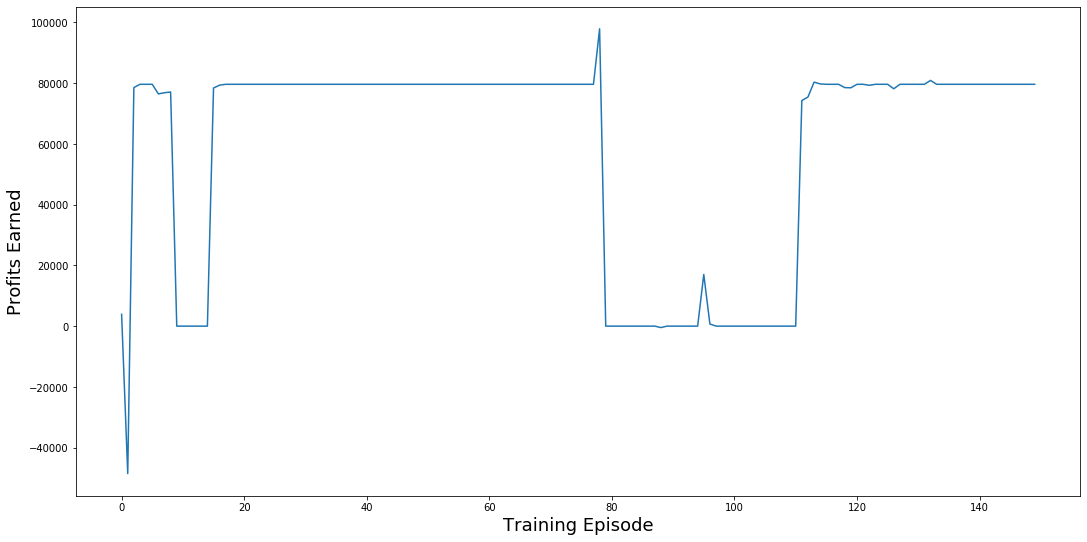

In [29]:
plt.figure(figsize = (18,9))
plt.plot(summary) # plotting by columns
plt.xlabel('Training Episode',fontsize=18)
plt.ylabel('Profits Earned',fontsize=18)
plt.show()

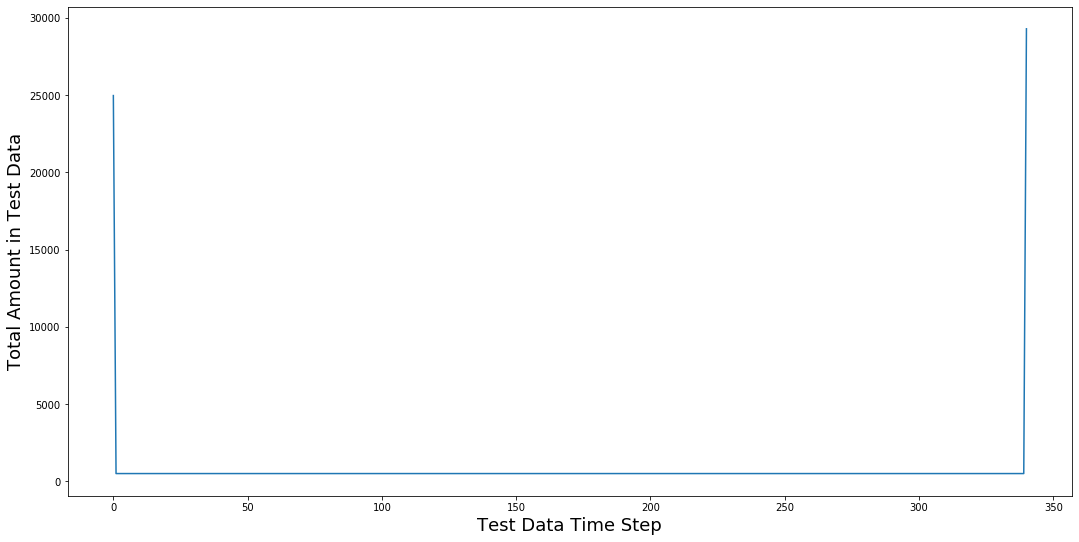

In [33]:
plt.figure(figsize = (18,9))
plt.plot(summary_test) # plotting by columns
plt.xlabel('Test Data Time Step',fontsize=18)
plt.ylabel('Total Amount in Test Data',fontsize=18)
plt.show()